## Imports

In [ ]:
import folium
from folium import plugins
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

# Read files

In [ ]:
data1 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/ambulance-data/ambulance_jan_01_10.parquet")
data2 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/ambulance-data/ambulance_jan_11_20.parquet")
data3 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/ambulance-data/ambulance_jan_21_31.parquet")
data4 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/ambulance-data/ambulance_feb_01_10.parquet")
data5 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/ambulance-data/ambulance_feb_11_20.parquet")
data6 = pd.read_parquet("https://iudx-cat-sandbox-dev.s3.ap-south-1.amazonaws.com/ambulance-data/ambulance_feb_21_28.parquet")

# Merge Datasets

In [ ]:
data = pd.concat([data1, data2, data3, data4, data5, data6],ignore_index=True)

In [ ]:
data["emergencyVehicleType"].value_counts()

AMBULANCE               4248872
                        1898192
MOTORCYCLE AMBULANCE     240924
Name: emergencyVehicleType, dtype: int64

The emergencyVehicleType has a lot of null values. We need to plot them later on. So, assigning them to NULL string.

In [ ]:
data = data.replace("","NULL")
data = data.drop_duplicates()
data.reset_index(inplace=True)

# Preprocess Data

## Read Latitudes and Longitudes

In [ ]:
data['latitude']=data['location.coordinates'].apply(lambda x:float(x.split(",")[1][:-1].strip()))
data['longitude']=data['location.coordinates'].apply(lambda x:float(x.split(",")[0][1:].strip()))

## Drop Columns

In [ ]:
data.drop(["location.coordinates", "location.type"], axis=1, inplace=True)

## Format DateTime

In [ ]:
data["observationDateTime"]=data['observationDateTime'].apply(lambda x:x.tz_localize('UTC').tz_convert("Asia/Kolkata"))
data["observationDateTime"]=data['observationDateTime'].apply(lambda x:datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S%z'))
data["observationDateTime"]=data['observationDateTime'].apply(lambda x:x.tz_localize(None))

In [ ]:
data.head()

index license_plate serviceOnDuty  \
0      0     KA51G5257           YES   
1      1     KA51G5026           YES   
2      2     KA02G3769            NO   
3      3     KA51G5022            NO   
4      4      KA40G430            NO   

                                                  id emergencyVehicleType  \
0  datakaveri.org/fb0924bef803e220e0d0bc8ceaf0a1f...            AMBULANCE   
1  datakaveri.org/fb0924bef803e220e0d0bc8ceaf0a1f...            AMBULANCE   
2  datakaveri.org/fb0924bef803e220e0d0bc8ceaf0a1f...            AMBULANCE   
3  datakaveri.org/fb0924bef803e220e0d0bc8ceaf0a1f...            AMBULANCE   
4  datakaveri.org/fb0924bef803e220e0d0bc8ceaf0a1f...            AMBULANCE   

  observationDateTime   latitude  longitude  
0 2022-01-01 01:52:33  12.916807  77.599144  
1 2022-01-01 01:52:34  13.020909  77.618980  
2 2022-01-01 01:52:34  12.918854  77.599800  
3 2022-01-01 01:52:37  12.937963  77.569817  
4 2022-01-01 01:52:38  12.984654  77.555244

# Remove Outlier Coordinates

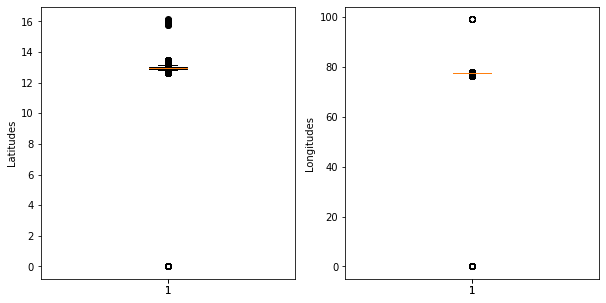

In [ ]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(ncols=2)
ax = gs.subplots(sharex=True)

ax[0].boxplot(data["latitude"])
ax[1].boxplot(data["longitude"])

ax[0].set_ylabel('Latitudes')
ax[1].set_ylabel('Longitudes')

plt.show()

Latitudes have outliers near 0 and 16 while longitudes have outliers near 0 and 100. We select data by applying condition on longitudes as it has more range than latitudes. It gives us more margin to select data.

In [ ]:
data = data[(data["longitude"]>=60) & (data["longitude"]<=90)]
data.reset_index(inplace=True)

The outliers have been removed now.

# Trend Analysis

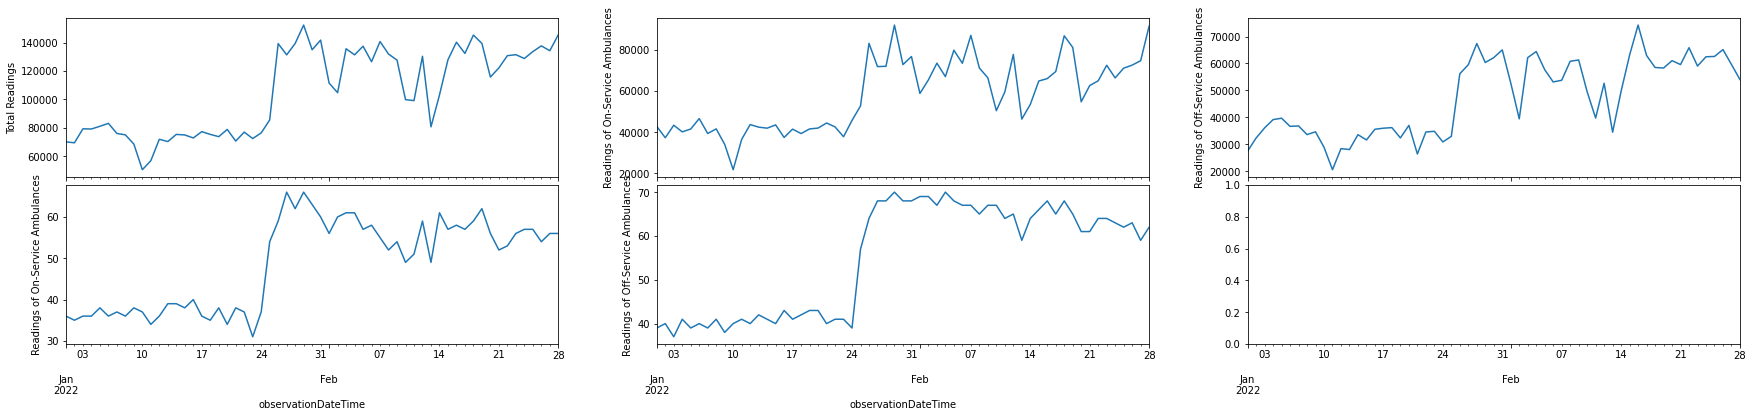

In [ ]:
daily_trend = data.groupby(data.observationDateTime.dt.floor('1D')).count()["id"]

on_service_daily_trend = data[data["serviceOnDuty"]=="YES"]
on_service_daily_trend = on_service_daily_trend.groupby(on_service_daily_trend.observationDateTime.dt.floor('1D')).count()["id"]

off_service_daily_trend = data[data["serviceOnDuty"]=="NO"]
off_service_daily_trend = off_service_daily_trend.groupby(off_service_daily_trend.observationDateTime.dt.floor('1D')).count()["id"]

fig = plt.figure(figsize=(30,6))
gs = fig.add_gridspec(2,3, hspace=0.05)
ax = gs.subplots(sharex=True)

daily_trend.plot(kind='line',ax=ax[0][0])
on_service_daily_trend.plot(kind='line',ax=ax[0][1])
off_service_daily_trend.plot(kind='line',ax=ax[0][2])

ax[0][0].set_ylabel('Total Readings')
ax[0][1].set_ylabel('Readings of On-Service Ambulances')
ax[0][2].set_ylabel('Readings of Off-Service Ambulances')


on_service_data = data[data["serviceOnDuty"]=="YES"]
on_service_data = on_service_data.groupby(on_service_data.observationDateTime.dt.floor('1D'))["license_plate"].nunique()

not_on_service_data = data[data["serviceOnDuty"]=="NO"]
not_on_service_data = not_on_service_data.groupby(not_on_service_data.observationDateTime.dt.floor('1D'))["license_plate"].nunique()

on_service_data.plot(kind='line',ax=ax[1][0])
not_on_service_data.plot(kind='line',ax=ax[1][1])

ax[1][0].set_ylabel('Readings of On-Service Ambulances')
ax[1][1].set_ylabel('Readings of Off-Service Ambulances')

plt.show()

These trends clearly show that the datapoints significantly increased in the month of February. The probable reason for that may be Covid as the demand for ambulances increased during the third wave.

# Number of Ambulances and Types

Number of ambulances: 74
AMBULANCE               36
NULL                    28
MOTORCYCLE AMBULANCE    10
Name: emergencyVehicleType, dtype: int64


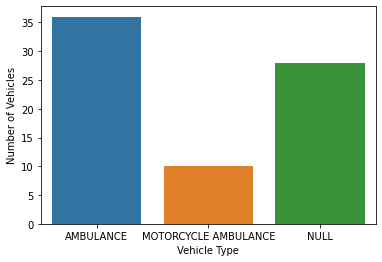

In [ ]:
license_plates=np.unique(data.license_plate)
print(f'Number of ambulances: {len(license_plates)}')
vehicle_data=data[['emergencyVehicleType','license_plate']].drop_duplicates().reset_index(drop=True)
print(vehicle_data['emergencyVehicleType'].value_counts())
ax=sns.countplot(data=vehicle_data,x='emergencyVehicleType')
plt.figure(1,dpi=300)
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Vehicles')
plt.show()

There are 28 ambulances which are not assigned to any category. They may either belong to the other two categories or belong to some other third category.

### On Duty vs. Off Duty readings

On Duty readings: 3417323
Off Duty readings: 2792454


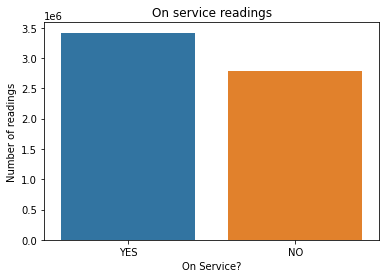

In [ ]:
print(f"On Duty readings: {data[data.serviceOnDuty=='YES'].shape[0]}")
print(f"Off Duty readings: {data[data.serviceOnDuty=='NO'].shape[0]}")
ax=sns.countplot(data=data,x='serviceOnDuty')
plt.figure(1,dpi=300)
plt.xlabel('On Service?')
plt.ylabel('Number of readings')
plt.title('On service readings')
plt.show()

### Area covered by Motorcycle Ambulances

In [ ]:
amb_data=data.query('emergencyVehicleType=="MOTORCYCLE AMBULANCE"')
map1=folium.Map()
map1.add_child(plugins.HeatMap(amb_data[['latitude','longitude']].values, radius=15))
map1.fit_bounds(map1.get_bounds())
map1

**Literature Survey**: The largest red patch on the heatmap is on the NICE road which is an accident-prone road. That is why motorcycle ambulances go to that area a lot.

# Trips made by an ambulance

In [ ]:
license_plate = "KA51G5026"
data_single_vehicle=data[(data['license_plate']==license_plate) & (data["observationDateTime"]>="2022-02-03 00:00") & (data["observationDateTime"]<="2022-02-04 00:00")]
on_duty=[]
off_duty=[]
coord=[]
onflag=True
for i, row in data_single_vehicle.iterrows():
    if row['serviceOnDuty']=="YES":
        if onflag==True:
            coord.append([row['latitude'],row['longitude']])
        else:
            coord.append([row['latitude'],row['longitude']])
            onflag=True
            off_duty.append(coord)
            coord=[[row['latitude'],row['longitude']]]
    else:
        if onflag==False:
            coord.append([row['latitude'],row['longitude']])
        else:
            coord.append([row['latitude'],row['longitude']])
            onflag=False
            on_duty.append(coord)
            coord=[[row['latitude'],row['longitude']]]
if onflag==True:
    on_duty.append(coord)
else:
    off_duty.append(coord)
    
map3=folium.Map()
coord=data_single_vehicle[['latitude','longitude']].values
for path in on_duty:
    folium.vector_layers.PolyLine(path,
                                  tooltip=license_plate,color='red'
                                  ,weight=5).add_to(map3)
for path in off_duty:
    folium.vector_layers.PolyLine(path,
                                  tooltip=license_plate,color='orange'
                                  ,weight=5).add_to(map3)
folium.Marker(location=list(coord[0]),tooltip="start").add_to(map3)
folium.Marker(location=list(coord[-1]),tooltip='end').add_to(map3)
map3.fit_bounds(map3.get_bounds())
map3